## a) SGD optimization

**Standard linear regression:**
The cost function is

\begin{align}
    c(\mathbf{\beta}) = \displaystyle\sum_{i = 0}^{N-1} (y_i - X_{i\ast}\mathbf{\beta})^2
\end{align}

The gradient is 

\begin{align}
    \nabla_{\beta} c(\mathbf{\beta}) = X^T (\mathbf{y} - X\mathbf{\beta})
\end{align}

Regular gradient descent: compute the gradient with all the data points.

\begin{align}
    \beta^{(k+1)} = \beta^{(k)} - \eta^{(k)}\nabla_{\beta}(c(\beta^{(k)})
\end{align}

Stochastic gradient descent: divide the data points into mini-batches of $M$ points ($n/M$ mini-batches). For each epoch compute $n/M$ gradients of random minibatches and update $\beta$.

In [1]:
def FrankeFunc(x, y):
    s1 = 0.75 * np.exp(-0.25*(9*x-2)**2 - 0.25*(9*y-2)**2)
    s2 = 0.75 * np.exp(-(9*x-2)**2/49 - (9*y-2)**2/10)
    s3 = 0.5 * np.exp(-0.25*(9*x-7)**2 - 0.25*(9*y-3)**2)
    s4 = -0.2 * np.exp(-(9*x-4)**2 - (9*y-7)**2)
    
    return s1+s2+s3+s4


# Mean squared error function
def MSE(y_data, y_model):
    return np.mean((y_data-y_model)**2)


# R2 score
def R2(y_data, y_model):
    y_mean = np.mean(y_data)
    return 1-np.sum( (y_data - y_model)**2 )/np.sum( (y_data-y_mean)**2 )


# Gradient of cost function
def gradOLS(X, y, beta):
    n = len(y)
    return 1/n * X.T @ (X @ beta - y)


def gradRidge(X, y, beta, lmd):
    n = len(y)
    return 1/n * (X.T @ (X @ beta - y) + lmd * beta)


def myRegression(X, y):
    return np.linalg.pinv(X.T @ X) @ X.T @ y


def myRidge(X, y, lmb):
    n_samp, n_feat = X.shape
    I = np.eye(n_feat)
    return np.linalg.pinv(X.T @ X + lmb*I) @ X.T @ y


def learning_rate(t, t0=5, t1=10):
    return t0/(t + t1)

**Analysis of linear regression with gradient descent**

Explore different learning rates, minibatch size and polynomial degree. The function *SGDRegression* preforms a stochastic gradient descent over a data set with a given gradient of the cost function.

In [27]:
def SGDRegression(X, y, M=5, n_eps=50):
    n = len(y)
    m = int(n/M)  # number of minibatches
    
    # initialize parameters
    beta = np.random.randn(X.shape[1], 1)
    indxs = np.arange(n)
    
    # Agorithm for SGD
    for epoch in range(n_eps):
        for i in range(m):
            rand_indx = np.random.choice(indxs, size=M, replace=False)
            X_i = X[rand_indx]
            y_i = y[rand_indx]
            t = epoch*m + i
            eta = learning_rate(t)
            
            gradient = gradOLS(X, y, beta)
            beta -= eta * gradient
    
    return beta

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import seaborn as sb
plt.style.use('seaborn')
np.random.seed(654654)

# Attempt on the Franke function
n = 600
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
y = FrankeFunc(x0, x1).reshape(-1, 1)

poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(x)

X_train, X_test = train_test_split(X, test_size=0.2)
y_train, y_test = train_test_split(y, test_size=0.2)

batch_size = np.arange(2, 8)
n_batch = len(batch_size)
eps = np.arange(30, 70, 5)
n_neps = len(eps)

results = np.zeros((n_neps, n_batch))
for i in range(n_neps):
    for j in range(n_batch):
        beta = SGDRegression(X_train, y_train, M=batch_size[j], n_eps=eps[i])
        y_prediction = X_test @ beta
        
        results[i, j] = MSE(y_test, y_prediction)

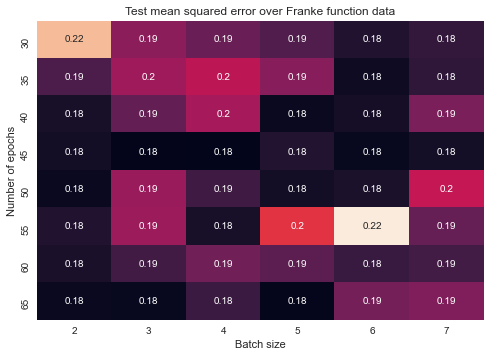

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sb.heatmap(results, ax=ax, annot=True, cbar=False)
ax.set_title('Test mean squared error over Franke function data')
ax.set_xlabel('Batch size')
ax.set_ylabel('Number of epochs')
ax.set_xticklabels(batch_size)
ax.set_yticklabels(eps)
plt.show()

In [6]:
# Comparison between analytical algorithm and SGD 
np.random.seed(654654)  # same data

n = 600
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
y = FrankeFunc(x0, x1).reshape(-1, 1)

poly = PolynomialFeatures(degree=2)
X = poly.fit_transform(x)

X_train, X_test = train_test_split(X, test_size=0.2)
y_train, y_test = train_test_split(y, test_size=0.2)

beta_analytical = myRegression(X_train, y_train)
y_pred = X_test @ beta_analytical
mse_an = MSE(y_test, y_pred)

print(f'MSE of analytical regression: {mse_an}')
print(f'MSE of SGD regression: {np.min(results)}')

MSE of analytical regression: 0.17919543491909318
MSE of SGD regression: 0.17756916877166276


Now repeat the analysis but for the ridge regression. This time we will study the performance of the SGD with respect to the regularization parameter and the learning rate.

In [33]:
def SGDRidge(X, y, lmd, eta, M=5, n_eps=50):
    n = len(y)
    m = int(n/M)  # number of minibatches
    
    # initialize parameters
    beta = np.random.randn(X.shape[1], 1)
    indxs = np.arange(n)
    
    # Agorithm for SGD
    for epoch in range(n_eps):
        for i in range(m):
            rand_indx = rand_indx = np.random.choice(indxs, size=M, replace=False)
            X_i = X[rand_indx]
            y_i = y[rand_indx]
            gradient = gradRidge(X, y, beta, lmd)
            beta -= eta * gradient
    
    return beta

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
import seaborn as sb
plt.style.use('seaborn')
np.random.seed(9876545)

n = 600
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
y = FrankeFunc(x0, x1)
y  = y.reshape(-1, 1)

poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n_etas = 6
n_lmds = 6
result = np.zeros((n_etas, n_lmds))

etas = np.logspace(-3, -1, n_etas)
lmds = np.logspace(-3, -1, n_lmds)

for k, eta in enumerate(etas):
    for j, lmd in enumerate(lmds):
        beta = SGDRidge(X_train, y_train, lmd, eta, M=3)
        y_pred = X_test @ beta
        result[k, j] = MSE(y_test, y_pred)

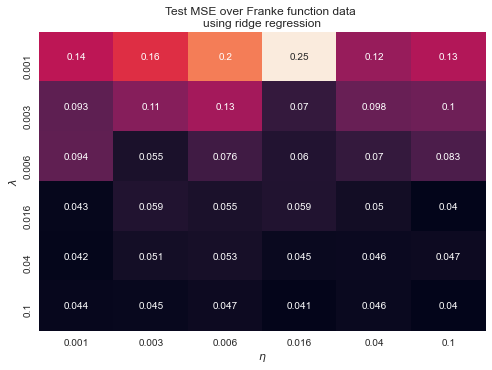

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sb.heatmap(result, ax=ax, annot=True, cbar=False)
ax.set_title('Test MSE over Franke function data \nusing ridge regression')
ax.set_xlabel(r'$\eta$')
ax.set_ylabel(r'$\lambda$')
ax.set_xticklabels(np.around(etas, decimals=3))
ax.set_yticklabels(np.around(lmds, decimals=3))
plt.show()

In [10]:
np.random.seed(9876545)

n = 600
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
y = FrankeFunc(x0, x1) 
y  = y.reshape(-1, 1)

poly = PolynomialFeatures(degree=3)
X = poly.fit_transform(x)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

indx = np.where(result == np.min(result))[1]
best_lmd = lmds[indx]

beta_analytical = myRidge(X_train, y_train, best_lmd)
y_pred = X_test @ beta_analytical
mse_an = MSE(y_test, y_pred)

print(f'MSE of analytical regression: {mse_an}')
print(f'MSE of SGD regression: {np.min(result)}')

MSE of analytical regression: 0.028789901221472444
MSE of SGD regression: 0.0399407619074744


**Logistic regression on the Haberman dataset**


**Neural network testing**

In [100]:
import autograd.numpy as np
from autograd import elementwise_grad
import matplotlib.pyplot as plt
import seaborn as sb
from neural import NeuralNetwork
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

# Dataset
n = 800
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
X = PolynomialFeatures(degree=3).fit_transform(x)
y = FrankeFunc(x0, x1).reshape(-1, 1) + 0.3*np.random.randn(n, 1)

# Data and NN characteristics
n_feat = X.shape[1]
n_cat = y.shape[1]
n_lay = 2
n_nodes = [10, 10]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

etas = np.logspace(-2.5, -1.5, 3)
lmds = np.logspace(-2, -1, 3)

for eta in etas:
    for lmd in lmds:
        nn = NeuralNetwork(X_train, y_train, n_lay, n_nodes, n_cat, 
                           output_activation=lambda t: t, n_eps=250, batch_size=50, eta=eta, lmd=lmd)
        nn.train()
        pred = nn.predict_probabilities(X_test)
        print(f'Learning rate: {eta}')
        print(f'Reguralization: {lmd}')
        print(f'MSE of neural network: {MSE(y_test, pred)}')
        print(f'R2 of neural network: {R2(y_test, pred)}')

        # Analytical lineal regression
        beta = myRidge(X_train, y_train, lmd)
        y_ridge = X_test @ beta
        print(f'MSE of ridge regression: {MSE(y_test, y_ridge)}')
        print(f'R2 of ridge regression_ {R2(y_test, y_ridge)}')
        print('-'*20)

Learning rate: 0.0031622776601683794
Reguralization: 0.01
MSE of neural network: 0.27286051776146797
R2 of neural network: -0.007312914890251987
MSE of ridge regression: 0.1121362947999367
R2 of ridge regression_ 0.5860290125277041
--------------------
Learning rate: 0.0031622776601683794
Reguralization: 0.03162277660168379
MSE of neural network: 0.27360924468304076
R2 of neural network: -0.010076972893270142
MSE of ridge regression: 0.11431871277167142
R2 of ridge regression_ 0.5779722301589967
--------------------
Learning rate: 0.0031622776601683794
Reguralization: 0.1
MSE of neural network: 0.2798884093434192
R2 of neural network: -0.03325762104644503
MSE of ridge regression: 0.12084525508466086
R2 of ridge regression_ 0.5538783435997139
--------------------
Learning rate: 0.01
Reguralization: 0.01
MSE of neural network: 0.142184208081076
R2 of neural network: 0.4751018202687872
MSE of ridge regression: 0.1121362947999367
R2 of ridge regression_ 0.5860290125277041
-----------------

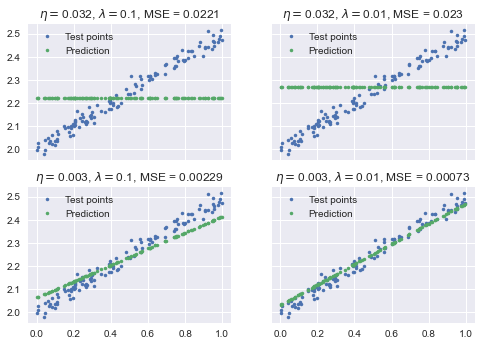

In [97]:
import autograd.numpy as np
from autograd import elementwise_grad
import matplotlib.pyplot as plt
import seaborn as sb
from neural import NeuralNetwork
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split

n = 600
x = np.random.rand(n)
X = np.array([np.ones(n), x]).T
y = 2.0 + 0.5*x + 0.02*np.random.randn(n)
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

etas = np.logspace(-2.5, -1.5, 2)
lmds = np.logspace(-2, -1, 2)
params = [(etas[0], lmds[0]), (etas[0], lmds[1]), (etas[1], lmds[0]), (etas[1], lmds[1])]

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
squares = [axs[0, 0], axs[0, 1], axs[1, 0], axs[1, 1]]

for i, (eta, lmbd) in enumerate(reversed(params)):
    nn = NeuralNetwork(X_train, y_train, 1, [10], 1, output_activation=lambda t: t, n_eps=200, batch_size=50, eta=eta, lmd=lmbd)
    nn.train()

    y_pred = nn.predict_probabilities(X_test)
    
    squares[i].plot(X_test[:, 1], y_test, '.', label='Test points')
    squares[i].plot(X_test[:, 1], y_pred, '.', label=f'Prediction')
    squares[i].set_title(fr'$\eta = ${round(eta, 3)}, $\lambda = ${lmbd}, MSE = {round(MSE(y_test, y_pred), 5)}')
    squares[i].legend()

plt.show()

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from neural import Layer, Network
from aux_funcs import mse, mse_prime, sigmoid, sigmoid_prime, tanh, tanh_prime, to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures


# Fitting Franke function
n = 800
x0, x1 = np.random.rand(n), np.random.rand(n)
x = np.array([x0, x1]).T
X = PolynomialFeatures(degree=3).fit_transform(x)
y = FrankeFunc(x0, x1).reshape(-1, 1) + 0.3*np.random.randn(n, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Data and NN characteristics
n_feat = X.shape[1]

acts = ['sigmoid', 'tanh', 'relu', 'leaky_relu']
lmds = np.logspace(-3, -1, 5)
mse_ridge = np.zeros(5)

dic = {}
for key in acts:
    dic[key] = np.zeros(5)

for i, lmd in enumerate(lmds):
    y_ridge = X_test @ myRidge(X_train, y_train, lmd)
    mse_ridge[i] = mse(y_test, y_ridge)

In [6]:
nn = Network()
nn.use_cost(mse, mse_prime)
    
nn.add_layer(Layer(n_feat, 10, activation='sigmoid'))
nn.add_layer(Layer(10, 10, activation='sigmoid'))
nn.add_layer(Layer(10, 1))


for i, lmd in enumerate(lmds):
    nn.train(X_train, y_train, epochs=150, batch=30, eta=0.01, lmd=lmd)
    y_pred = nn.predict_probabilities(X_test)
    dic['sigmoid'][i] = mse(y_test, y_pred)

In [3]:
nn = Network()
nn.use_cost(mse, mse_prime)
    
nn.add_layer(Layer(n_feat, 10, activation='tanh'))
nn.add_layer(Layer(10, 10, activation='tanh'))
nn.add_layer(Layer(10, 1))


for i, lmd in enumerate(lmds):
    nn.train(X_train, y_train, epochs=150, batch=30, eta=0.01, lmd=lmd)
    y_pred = nn.predict_probabilities(X_test)
    dic['tanh'][i] = mse(y_test, y_pred)

In [4]:
nn = Network()
nn.use_cost(mse, mse_prime)
    
nn.add_layer(Layer(n_feat, 10, activation='relu'))
nn.add_layer(Layer(10, 10, activation='relu'))
nn.add_layer(Layer(10, 1))


for i, lmd in enumerate(lmds):
    nn.train(X_train, y_train, epochs=150, batch=30, eta=0.01, lmd=lmd)
    y_pred = nn.predict_probabilities(X_test)
    dic['relu'][i] = mse(y_test, y_pred)

In [5]:
nn = Network()
nn.use_cost(mse, mse_prime)
    
nn.add_layer(Layer(n_feat, 10, activation='leaky_relu'))
nn.add_layer(Layer(10, 10, activation='leaky_relu'))
nn.add_layer(Layer(10, 1))


for i, lmd in enumerate(lmds):
    nn.train(X_train, y_train, epochs=150, batch=30, eta=0.01, lmd=lmd)
    y_pred = nn.predict_probabilities(X_test)
    dic['leaky_relu'][i] = mse(y_test, y_pred)

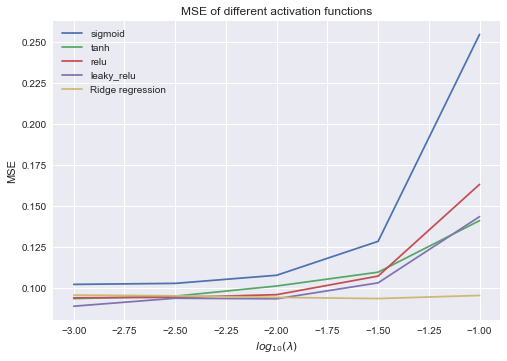

In [8]:
plt.style.use('seaborn')

for keys, vals in dic.items():
    plt.plot(np.log10(lmds), vals, label=keys)
    
plt.plot(np.log10(lmds), mse_ridge, label='Ridge regression')
plt.xlabel(r'$log_{10}(\lambda)$')
plt.ylabel('MSE')
plt.title('MSE of different activation functions')
plt.legend()

plt.show()

# Wisconsin Breast Cancer with neural network

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from neural import Layer, Network
from aux_funcs import mse, mse_prime, sigmoid, sigmoid_prime, tanh, tanh_prime, to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets
from sklearn.metrics import accuracy_score

'''Wisconsin breast cancer data using neural network'''

data = datasets.load_breast_cancer()
X, y = data.data, data.target.reshape(-1, 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

n_samples, n_features = X_train.shape

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

In [9]:
# Only 1 layer, sigmoid activation

net = Network()
net.use_cost(mse, mse_prime)

w = [n_features, 16, 1]
for i in range(len(w)-1):
    net.add_layer(Layer(w[i], w[i+1], 'sigmoid'))

etas = np.logspace(-3, -1, 3)
lmds = np.logspace(-3, 1, 5)
acc_sigmoid = np.zeros((3, 5))

net.train(X_train_scaled, y_train, epochs=70, batch=50, eta=0.01, lmd=0.0)
probs = net.predict_probabilities(X_test_scaled)

for i, eta in enumerate(etas):
    for j, lmd in enumerate(lmds):
        net.train(X_train_scaled, y_train, epochs=70, batch=50, eta=eta, lmd=lmd)
        probs = net.predict_probabilities(X_test_scaled)
        probs[probs >= 0.5] = 1
        probs[probs < 0.5] = 0
        acc_sigmoid[i, j] = accuracy_score(y_test, probs)

In [10]:
# Only 1 layer, tanh activation

net = Network()
net.use_cost(mse, mse_prime)

w = [n_features, 16, 1]
for i in range(len(w)-1):
    net.add_layer(Layer(w[i], w[i+1], 'tanh'))

etas = np.logspace(-3, -1, 3)
lmds = np.logspace(-3, 1, 5)
acc_tanh = np.zeros((3, 5))

for i, eta in enumerate(etas):
    for j, lmd in enumerate(lmds):
        net.train(X_train_scaled, y_train, epochs=70, batch=50, eta=eta, lmd=lmd)
        probs = net.predict_probabilities(X_test_scaled)
        probs[probs >= 0.5] = 1
        probs[probs < 0.5] = 0
        acc_tanh[i, j] = accuracy_score(y_test, probs)

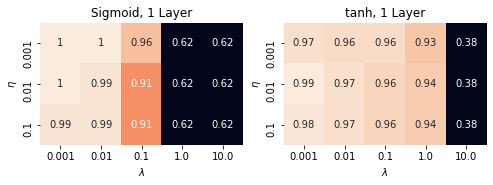

In [22]:
fig = plt.figure(figsize=(8, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sb.heatmap(acc_sigmoid, ax=ax1, square=True, annot=True, cbar=False)
sb.heatmap(acc_tanh, ax=ax2, square=True, annot=True, cbar=False)

ax1.set_title('Sigmoid, 1 Layer')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel(r'$\eta$')
ax1.set_xticklabels(lmds)
ax1.set_yticklabels(etas)

ax2.set_title('tanh, 1 Layer')
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'$\eta$')
ax2.set_xticklabels(lmds)
ax2.set_yticklabels(etas)

plt.show()

# MNIST analysis
### Warning! Long calculation time needed

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from neural import Layer, Network
from aux_funcs import mse, mse_prime, sigmoid, sigmoid_prime, tanh, tanh_prime, to_categorical
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from keras.datasets import mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
images = x_test[0:300]
# save only a few datapoints
x_train, y_train = x_train[0:700], y_train[0:700]
x_test, y_test = x_test[0:300], y_test[0:300]

n_samples = len(x_train)
n_features = int(x_train.shape[1]**2)
x_train = x_train.reshape(n_samples, n_features).astype('float32')
x_test = x_test.reshape(len(x_test), n_features).astype('float32')

scaler = MinMaxScaler()
scaler.fit(x_train)

x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.fit_transform(x_test)

y_train_onehot = to_categorical(y_train, 10)

etas = np.logspace(-2, -1, 2)
lmds = np.logspace(-3, -1, 3)

In [40]:
# Relu activation
acc_relu = np.zeros((2, 3))

model = Network()
model.use_cost(mse, mse_prime)

model.add_layer(Layer(n_features, 16, activation='relu'))
model.add_layer(Layer(16, 16, activation='relu'))
model.add_layer(Layer(16, 10, activation='relu'))

for i, eta in enumerate(etas):
    for j, lmd in enumerate(lmds):
        model.train(x_train_scaled, y_train_onehot, epochs=30, batch=100, eta=eta, lmd=lmd)
        pred = model.predict_values(x_test_scaled)
        acc_relu[i, j] = accuracy_score(y_test, pred)

C:\Users\noelg\4_Fisica\ML\Projects\Project 2\neural.py:47: RuntimeWarning: overflow encountered in matmul
  delta = np.matmul(output_error, self.weigths.T) * self.activation_prime(self.input)
C:\Users\noelg\4_Fisica\ML\Projects\Project 2\neural.py:47: RuntimeWarning: invalid value encountered in matmul
  delta = np.matmul(output_error, self.weigths.T) * self.activation_prime(self.input)
C:\Users\noelg\4_Fisica\ML\Projects\Project 2\neural.py:48: RuntimeWarning: invalid value encountered in matmul
  weigths_grad = np.matmul(self.input.T, output_error)
C:\Users\noelg\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


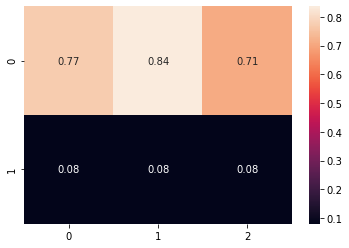

In [41]:
sb.heatmap(acc_relu, annot=True)
plt.show()

In [42]:
acc_tanh = np.zeros((2, 3))

model = Network()
model.use_cost(mse, mse_prime)

model.add_layer(Layer(n_features, 16, activation='tanh'))
model.add_layer(Layer(16, 16, activation='tanh'))
model.add_layer(Layer(16, 10, activation='tanh'))

for i, eta in enumerate(etas):
    for j, lmd in enumerate(lmds):
        model.train(x_train_scaled, y_train_onehot, epochs=30, batch=100, eta=eta, lmd=lmd)
        pred = model.predict_values(x_test_scaled)
        acc_tanh[i, j] = accuracy_score(y_test, pred)

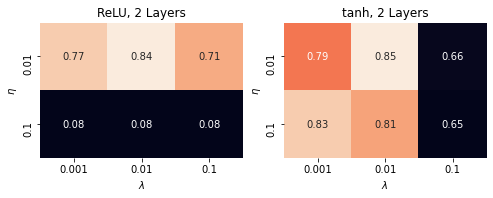

In [43]:
fig = plt.figure(figsize=(8, 20))
ax1 = fig.add_subplot(1, 2, 1)
ax2 = fig.add_subplot(1, 2, 2)

sb.heatmap(acc_relu, ax=ax1, square=True, annot=True, cbar=False)
sb.heatmap(acc_tanh, ax=ax2, square=True, annot=True, cbar=False)

ax1.set_title('ReLU, 2 Layers')
ax1.set_xlabel(r'$\lambda$')
ax1.set_ylabel(r'$\eta$')
ax1.set_xticklabels(lmds)
ax1.set_yticklabels(etas)

ax2.set_title('tanh, 2 Layers')
ax2.set_xlabel(r'$\lambda$')
ax2.set_ylabel(r'$\eta$')
ax2.set_xticklabels(lmds)
ax2.set_yticklabels(etas)

plt.show()

In [53]:
model = Network()
model.use_cost(mse, mse_prime)

model.add_layer(Layer(n_features, 16, activation='tanh'))
model.add_layer(Layer(16, 16, activation='tanh'))
model.add_layer(Layer(16, 10, activation='tanh'))

model.train(x_train_scaled, y_train_onehot, epochs=70, batch=60, eta=0.01, lmd=0.03, display=True)
fine_pred = model.predict_values(x_test_scaled)

Epoch 1, error=0.08836306056055479
Epoch 11, error=0.024178790156732365
Epoch 21, error=0.019698313181417
Epoch 31, error=0.018657780461506235
Epoch 41, error=0.017551562645689724
Epoch 51, error=0.016653560504215844
Epoch 61, error=0.015827209182805474


In [54]:
print(accuracy_score(y_test, fine_pred.ravel()))

0.89


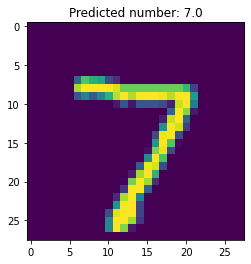

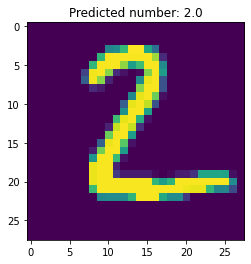

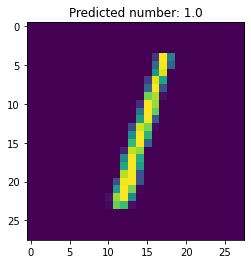

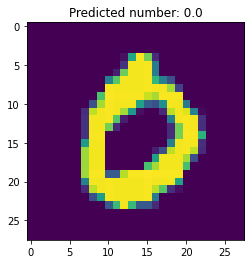

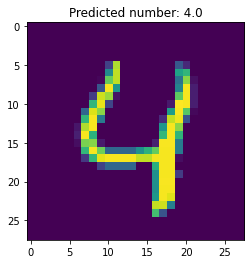

In [58]:
for i in range(5):
    plt.imshow(images[i])
    plt.title(f'Predicted number: {fine_pred.ravel()[i]}')
    plt.show()

# Logistic regression on Winsconsin Breast Cancer dataset

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from logistic import LogisticRegressor
from aux_funcs import to_categorical
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

cancer_data = datasets.load_breast_cancer()
samples, targets = cancer_data.data, cancer_data.target.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(samples, targets, test_size=0.2)

scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lmds = np.logspace(-3, -0.5, 5)
etas = np.logspace(-3, -1, 5)
acc_log = np.zeros((5, 5))

for i, eta in enumerate(etas):
    for j, lmd in enumerate(lmds):
        log = LogisticRegressor(X_train_scaled, y_train, eta=eta, lmd=lmd)
        log.train()
        pred = log.predict_val(X_test_scaled)
        acc_log[i, j] = accuracy_score(y_test, pred)

C:\Users\noelg\4_Fisica\ML\Projects\Project 2\aux_funcs.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))
C:\Users\noelg\4_Fisica\ML\Projects\Project 2\aux_funcs.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))
C:\Users\noelg\4_Fisica\ML\Projects\Project 2\aux_funcs.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1 + np.exp(-z))


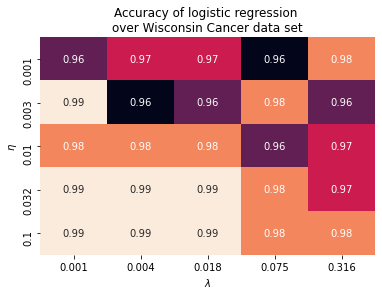

In [12]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
sb.heatmap(acc_log, ax=ax, annot=True, cbar=False)
ax.set_title('Accuracy of logistic regression \nover Wisconsin Cancer data set')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$\eta$')
ax.set_xticklabels(np.around(lmds, decimals=3))
ax.set_yticklabels(np.around(etas, decimals=3))
plt.show()

# Logistic regression in Haberman's data set

In [26]:
import pandas as pd

names = ['x0', 'x1', 'x2', 'y']
data = pd.read_table('haberman.data', sep=',', names=names, header=None)

X = np.array(data.iloc[:, 0:3])
y = np.array(data.iloc[:, -1]) - 1
y = y.reshape(-1, 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled, X_test_scaled = scaler.fit_transform(X_train), scaler.fit_transform(X_test)

lmds = np.logspace(-3, -0.5, 2)
etas = np.logspace(-3, -1, 2)

for n_eps in np.arange(280, 290, 4):
    print(f'Number of epochs: {n_eps}')
    for i, eta in enumerate(etas):
        for j, lmd in enumerate(lmds):
            log = LogisticRegressor(X_train_scaled, y_train, n_eps=n_eps, batch_size=70, eta=eta, lmd=lmd)
            log.train()
            pred = log.predict_val(X_test_scaled)
            print(f'Learning rate: {eta}')
            print(f'Regularization: {lmd}')
            print('Accuracy score over test data: ', accuracy_score(y_test, pred))   
            print('-'*20)
    print('-'*60)

Number of epochs: 280
Learning rate: 0.001
Regularization: 0.001
Accuracy score over test data:  0.8064516129032258
--------------------
Learning rate: 0.001
Regularization: 0.31622776601683794
Accuracy score over test data:  0.8064516129032258
--------------------
Learning rate: 0.1
Regularization: 0.001
Accuracy score over test data:  0.7903225806451613
--------------------
Learning rate: 0.1
Regularization: 0.31622776601683794
Accuracy score over test data:  0.7580645161290323
--------------------
------------------------------------------------------------
Number of epochs: 284
Learning rate: 0.001
Regularization: 0.001
Accuracy score over test data:  0.8225806451612904
--------------------
Learning rate: 0.001
Regularization: 0.31622776601683794
Accuracy score over test data:  0.8225806451612904
--------------------
Learning rate: 0.1
Regularization: 0.001
Accuracy score over test data:  0.7419354838709677
--------------------
Learning rate: 0.1
Regularization: 0.31622776601683794